### EM, Heirarchical Clustering and HMM

We will: 1. implement expectation-maximization to train a word-sense induction system; 2. implement Heirarchical Clustering for Name Entity Tagging; 3. implement Viterbi Algorithm based on Hidden Markov Model for Part-of-speech tagging. 

#  Expectation Maximization

For this part, you will implement question 4 of chapter 5 from the reference book: Introduction to Natural Language Processing (Jacob Eisentein). We recommend you to read from the beginning of chapter 5 to section 5.2.1. Here are some formulas for reference:

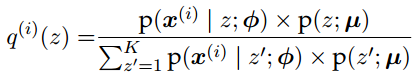

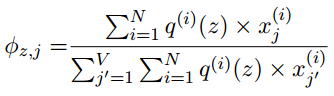

Use expectation-maximization clustering to train a word-sense induction system, applied to the word 'say'.  
• 1.1 Import NLTK, run NLTK.DOWNLOAD() and select SEMCOR. Import SEMCOR from NLTK.CORPUS.  
• 1.2 The command SEMCOR.TAGGED_SENTS(TAG=’SENSE’) returns an iterator over sense-tagged sentences in the corpus. Each sentence can be viewed as an iterator over TREE objects. For TREE objects that are sense-annotated words, you can access the annotation as TREE.LABEL(), and the word itself with TREE.LEAVES(). So SEMCOR.TAGGED_SENTS(TAG=’SENSE’)[0][2].LABEL() would return the sense annotation of the third word in the first sentence.  
• 1.3 Extract all sentences containing the senses SAY.V.01 and SAY.V.02.  
• 2. Build bag-of-words vectors x(i), containing the counts of other words in those sentences, including all words that occur in at least two sentences.  
• 3.1 Implement and run expectation-maximization clustering on the merged data.  
• 3.2 Compute the frequency with which each cluster includes instances of SAY.V.01 and SAY.V.02.

The following code is based on Multinomial distribution. You are free to use another one, like Gaussian distribution.

In [ ]:
!pip install svgling
import svgling

import nltk
nltk.download('semcor')
from nltk.corpus import semcor

import numpy as np
from scipy.stats import multinomial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.1 MB/s 


[nltk_data] Downloading package semcor to /root/nltk_data...


## 1. Extract all sentences containing the senses SAY.V.01 and SAY.V.02.

In [ ]:
from collections import Counter
# get tagged sentences
tagged_sents = semcor.tagged_sents(tag=('sense'))

# tokenize sentences
sentences = []
tokens = set()

# counts of sentences with say.v.01/say.v.02
labels = [] #1/2
labels1_cnt = 0
labels2_cnt = 0

for sent in tagged_sents:
  label = []
  sentence = []
  F1 = False
  F2 = False
  for s in sent:
    if s.label() == 'say.v.01' or s.label() == 'say.v.02':
      label.append(s.label())
      F2 = True
    else: 
      sentence += s.leaves()

  if not F1 and 'say.v.01' in label:
    labels.append(1)
    labels1_cnt += 1
    F1 = True

  if not F1 and 'say.v.02' in label:
    labels.append(2)
    labels2_cnt += 1
    F1 = True
  if F2:
    sentences.append(sentence)
    tokens.update(sentence) 

In [ ]:
# show 5 samples
print(labels[:5])

for sts in sentences[:5]:
  print(' '.join(sts))

[1, 1, 1, 2, 2]
The Fulton County Grand Jury Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further in term end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury it did find that many of Georgia 's registration and election laws `` are outmoded or inadequate and often ambiguous '' .
The grand jury commented on a number of other topics , among them the Atlanta and Fulton County purchasing departments which it `` are well operated and follow generally accepted practices which inure to the best interest of both governments '' .


In [ ]:
ExpectedOutput='''
[1, 1, 1, 2, 2]
The Fulton County Grand Jury Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further in term end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury it did find that many of Georgia 's registration and election laws `` are outmoded or inadequate and often ambiguous '' .
The grand jury commented on a number of other topics , among them the Atlanta and Fulton County purchasing departments which it `` are well operated and follow generally accepted practices which inure to the best interest of both governments '' .'''

## 2. Build bag-of-words vectors x(i), containing the counts of other words in those sentences, including all words that occur in at least two sentences.

In [ ]:
# words that occur in at least two sentences
vocab = []

for token in tokens:
  count = 0
  for sentence in sentences:
    if token in sentence:
      count += 1

      if count >= 2:
        vocab.append(token)
        break


In [ ]:
N = len(sentences)
V = len(vocab)

print('Number of sentences:', N)
print('Size of vocabulary:', V)

print('Number of sentences with say.v.01:', labels1_cnt)
print('Number of sentences with say.v.02:', labels2_cnt)

Number of sentences: 1849
Size of vocabulary: 2760
Number of sentences with say.v.01: 1646
Number of sentences with say.v.02: 203


## Expected Output:  
Number of sentences: 1849  
Size of vocabulary: 2760  
Number of sentences with say.v.01: 1646  
Number of sentences with say.v.02: 203  

In [ ]:
# Create a dictionary to keep track of index of each word
dict_idx = {}

### Your Code Goes Here ###
index = 0
for word in vocab:
    dict_idx[word] = index
    index += 1

In [ ]:
# Finally, the bag-of-words 2D vector:
X = np.zeros((N,V)) # input data
L = np.zeros(N)     # number of tokens in each line

### Your Code Goes Here ###
for i in range(len(sentences)):
  for token in sentences[i]:
    if token in dict_idx:
      L[i] += 1
      index = dict_idx[token]
      X[i][index] += 1    

## 3. Implement expectation-maximization clustering on the data.  

Thses are the variables used in the following:  

k: the number of clusters: 2  
F: the φ in the formula, shape: (k,V)  
U: the prior expected frequency, shape: (k)  
Q: the posterior probability, p(z|X), shape: (N,k)

In [ ]:
from numpy.random.mtrand import multivariate_normal
# =============================================================================#
'''
Initialize latent parameters.
'''
import numpy as np

def initialize_FU(k):
    ### Your Code Goes Here ###
    U = np.random.random(k)    
    F = np.random.random((k,V))
    U_sum = sum(U)
    U = U/U_sum
    for i in range(k):
      U_sum = sum(F[i])
      F[i] = F[i]/U_sum

    return F,U


In [ ]:
# =============================================================================#
def calculate_Q(k, F,U):
    '''
    Calculate the soft distribution over clusters for each data point.
    '''
    Q = np.zeros((N,k))
    for z in range(k):
      pmf = multinomial.pmf(x= X, n= L, p= F[z])
      Q[:,z] = pmf * U[z] 

    for i in range(N):
      s = sum(Q[i])
      Q[i]/= s
    
    return Q

In [ ]:
# =============================================================================#
def update_FU(k, Q):
    '''
    Update the multinomial distribution parameters F and the cluster prior U.
    '''
    F = np.zeros((k,V))
    U = np.zeros(k)

    ### Your Code Goes Here ###

    for i in range(k):
      for j in range(V):
        F[i][j] = np.dot(Q[:, i], X[:, j])
    for i in range(k):
      row_sum = sum(F[i])
      F[i] = F[i]/row_sum
    for i in range(k):
      U[i] = sum(Q[:,i ])
    row_sum = sum(U)
    U = U/row_sum
    return F,U

In [ ]:
# =============================================================================#
def em_algorithm(k, iterations):
    F, U = initialize_FU(k)
    ### Your Code Goes Here ###
    for i in range(iterations):
      Q = calculate_Q(k,F,U)
      F, U = update_FU(k,Q) 
        
    return Q, F,U


## 3.1 Run EM clustering on a sample data.

In [ ]:
# save
saveX = X
saveL = L
saveN = N
saveV = V

# sample data
X = np.array([[2,5],
              [4,4],
              [1,8],
              [6,2],
              [8,2]])
L = [7,8,9,8,10]
N = 5
V = 2

# run EM
Q, F,U = em_algorithm(2, 50)

print('U:\n', U)
print('F:\n', F)
print('Q:\n', Q)

# reload
X = saveX
L = saveL
N = saveN
V = saveV

U:
 [0.57409616 0.42590384]
F:
 [[0.69366968 0.30633032]
 [0.21927119 0.78072881]]
Q:
 [[1.11465036e-01 8.88534964e-01]
 [7.61890820e-01 2.38109180e-01]
 [2.38958957e-03 9.97610410e-01]
 [9.95215486e-01 4.78451404e-03]
 [9.99519858e-01 4.80142220e-04]]


In [ ]:
ExpectedOutput='''
U:
 [0.57409618 0.42590382]
F:
 [[0.69366967 0.30633033]
 [0.21927117 0.78072883]]
Q:
 [[1.11465074e-01 8.88534926e-01]
 [7.61890909e-01 2.38109091e-01]
 [2.38959048e-03 9.97610410e-01]
 [9.95215489e-01 4.78451129e-03]
 [9.99519858e-01 4.80141881e-04]]
'''

##3.2 Compute the frequency of each cluster.

In [ ]:
# fix the run
np.random.seed(1)

k = 2
iterations = 50
Q, F,U = em_algorithm(k, iterations)

print('Cluster Frequency:', U)

In [ ]:
# compute the cluster assignment accuracy
acc = 0

### Your Code Goes Here ###

for i, q in enumerate(Q):
  if q[0] > q[1] and labels[i] == 1:
    acc += 1
  elif q[0] < q[1] and labels[i] ==2:
    acc += 1

print('Accuracy:', acc/N)

**|Is it stable? Why?**


The result is very unstable owing to the method we use to initialize our latent variable parameters. Since there is a random function involved, for different values of seed, we get different accuracies, and for most values of seed, we obtain NaN values. If there was a standard method to initializing the latent variables, the model would be significantly more stable.

#Hierarchical Clustering

## Part 1

In this section we will download articles from wikipedia and then cluster them into groups in the next step. You can select somewhat related topics or fetch the articles randomly. 
(Use dir() and help() functions or refer wikipedia documentation)

https://wikipedia.readthedocs.io/en/latest/code.html#api

In [ ]:
pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### importing dependencies ###

import wikipedia
from wikipedia.exceptions import WikipediaException
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import numpy as npm

In [ ]:
'''
 Generate a list of wikipedia article titles to cluster 
 You can maintain a static list of titles or generate them randomly using wikipedia library
 Some topics include:
 ["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", "Finance" ,
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football", "Cricket"]0

 You can add more topics from different categories so that we have a diverse datset to work with. 
 Ex- About 10+ categories with 3+ article in each category
'''
# 'article' is a list containing the names of articles to be downloaded
article = ["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Engineering Management" , "Library" , "Cafeteria" , "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Chase Bank" , "Visa Inc.",  "European Central Bank", "Bank", "World War" , "Student loans" , "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]
print (len(article))
# download and store all the articles in this variable
data = [wikipedia.summary(topic, auto_suggest = False) for topic in article]
data


## Task 2

In this step you will decide whether to clean the data or not.

Why are you (or not) choosing to clean the data? Think in terms of whether cleaning the data will help in the clustering or not.

Before vectorizing my data, I decided to clean it up. Because of the absence of uniformity, punctuation characters, digits, and upper case letters treat a word as if it were a different one. Clustering results will be influenced by the occurrence of stop words in high frequency. It's also critical to feed your data to the model in a fashion that the model understands in order for the model to achieve maximum accuracy and efficiency.

In [ ]:
# You can use Assignment 1's clean text function
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

def clean_text(text):
    text = text.lower() #Converting the text to lowercase
    text = re.sub(r'[^\w\s]', '', text) #Removing the punctuations in the text using regex
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #Removing the links in the text using regex
    text_cleaned = word_tokenize(text) #This function is to tokenize the text
    text_cleaned = [r for r in text_cleaned if r not in stopwords.words("english")] #Removing the stop words from the list of tokens
    wn = nltk.WordNetLemmatizer()
    text_cleaned = [wn.lemmatize(x) for x in text_cleaned] #This function is to lemmatize the text
    text_cleaned = ' '.join(word for word in text_cleaned)

    return text_cleaned



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cleaned_data = []
for text in data:
  cleaned = clean_text(text)
  cleaned_data.append(cleaned)

In [ ]:
df_data = [[sentences] for sentences in data]
# Converting it into a pandas dataframe 
# data = data.split()
import numpy as np
df = pd.DataFrame(np.array(df_data), columns = ["Related Data"] ,index=["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Engineering Management" , "Library" , "Cafeteria" , "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Chase Bank" , "Visa Inc.",  "European Central Bank", "Bank", "World War" , "Student loans" , "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"])
df

,Related Data
Northeastern Unversity,Northeastern University (NU or NEU) is a priva...
Natural language processing,Natural language processing (NLP) is a subfiel...
Machine learning,Machine learning (ML) is a field of inquiry de...
Quantum machine learning,Quantum machine learning is the integration of...
Engineering Management,Engineering management is the application of t...
Library,"A library is a collection of materials, books ..."
Cafeteria,"A cafeteria, sometimes called a canteen outsid..."
Artificial intelligence,Artificial intelligence (AI) is intelligence d...
Data science,Data science is an interdisciplinary field tha...
Master in Data Science,A Master of Science in Data Science is an inte...


## Task 3

In this step, we will vectorize the text data to use in hierarchical clustering. You can use countVectorizer() or TfidfVectorizer() from sklearn library.

In [ ]:
### vectorize the dataset using count vectorizer or tfidf vectorizer and store the vectors in a separate variable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vecs = None

# Creating object for the tfidf vectorizer 
vectorizer = TfidfVectorizer()
embedded_vecs = vectorizer.fit_transform(data)

## Task 4

Plot the Dendrogram and try to see the heirarchical relationships between articles.

In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(embedded_vecs.todense() , 'ward')

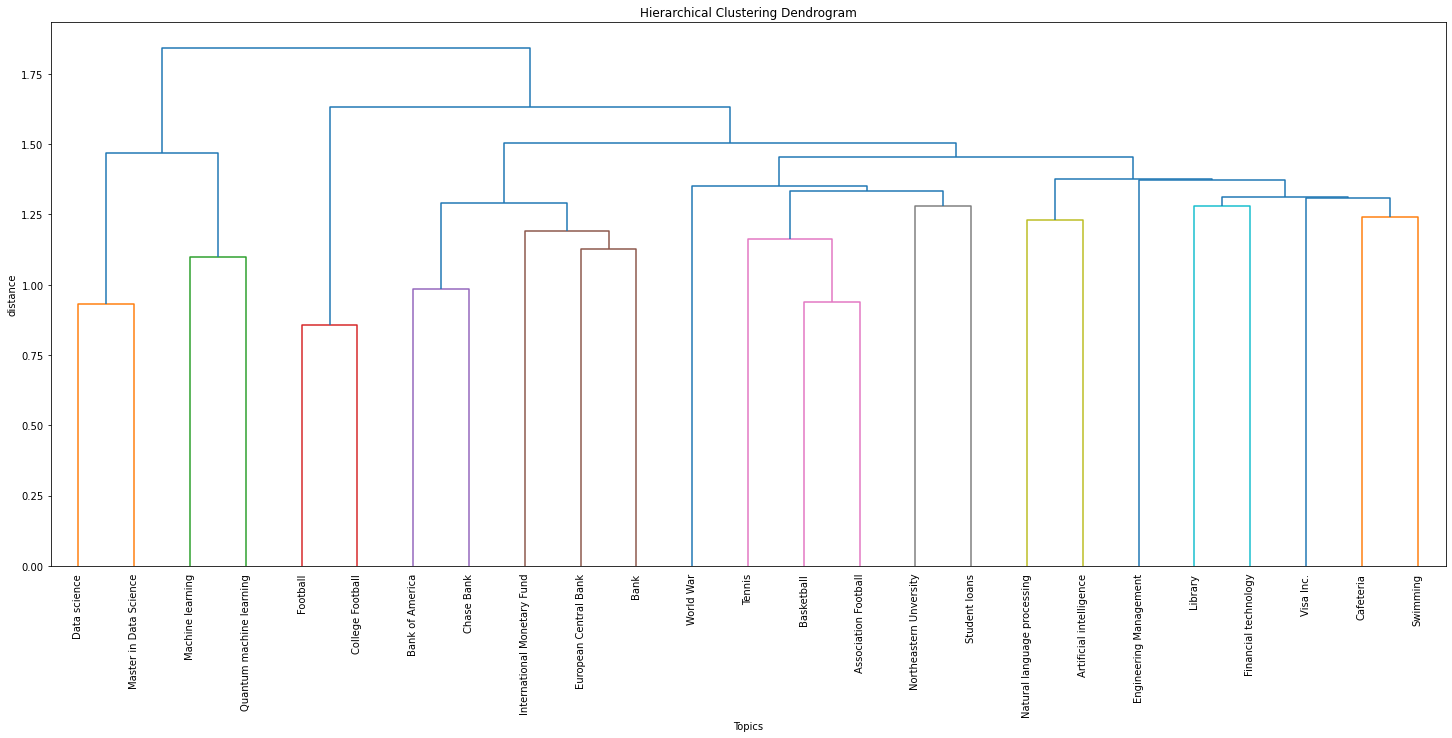

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Topics')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels = df.index
)
plt.show()

## Task 4

In this step, we will assign cluster lables to each document/group using Agglomerative Hierarchical clustering.
We can decide number of clusters based on the dendogram and our requirement (how many categories we want).(eg. n_clusters = 3) 

In [ ]:
### importing dependencies for agglomerative clustering ###
from sklearn.cluster import AgglomerativeClustering

### perform agglomerative clustering on the vectors

aggclust = AgglomerativeClustering(n_clusters=5)
clustering = aggclust.fit(embedded_vecs.todense())
clusters_formed = clustering.labels_
clusters_formed

### Below output is just for your reference purposes.
###Your output is not going to be the same as the output provided below as the list of articles is going to be different  

array([0, 0, 3, 3, 0, 0, 0, 0, 4, 4, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       2, 2, 0])

## Task 5

Now, we will try to visualize top 50 words in each cluster using word clouds

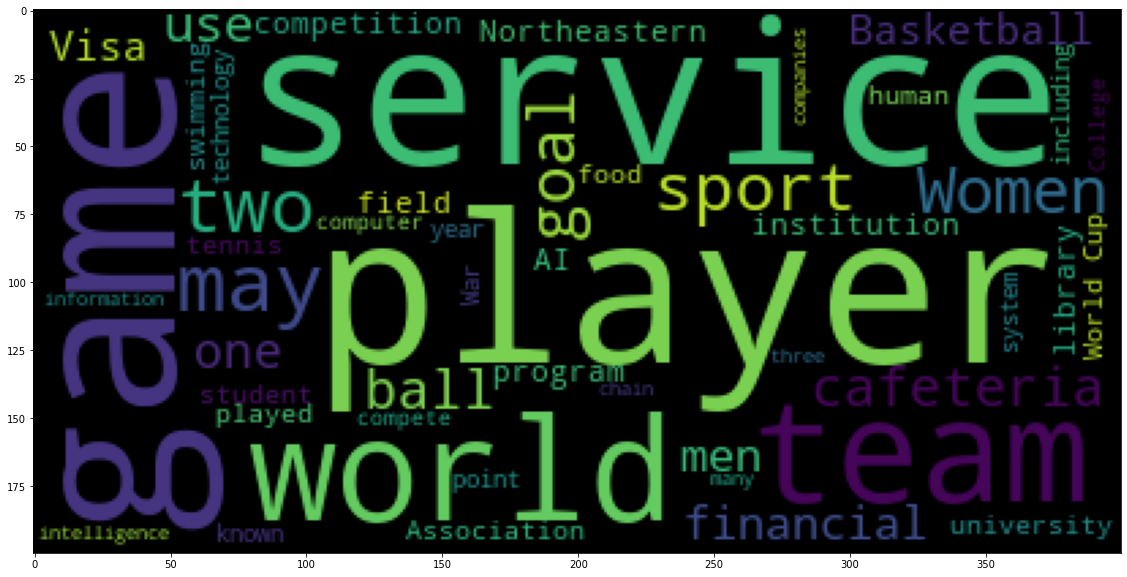

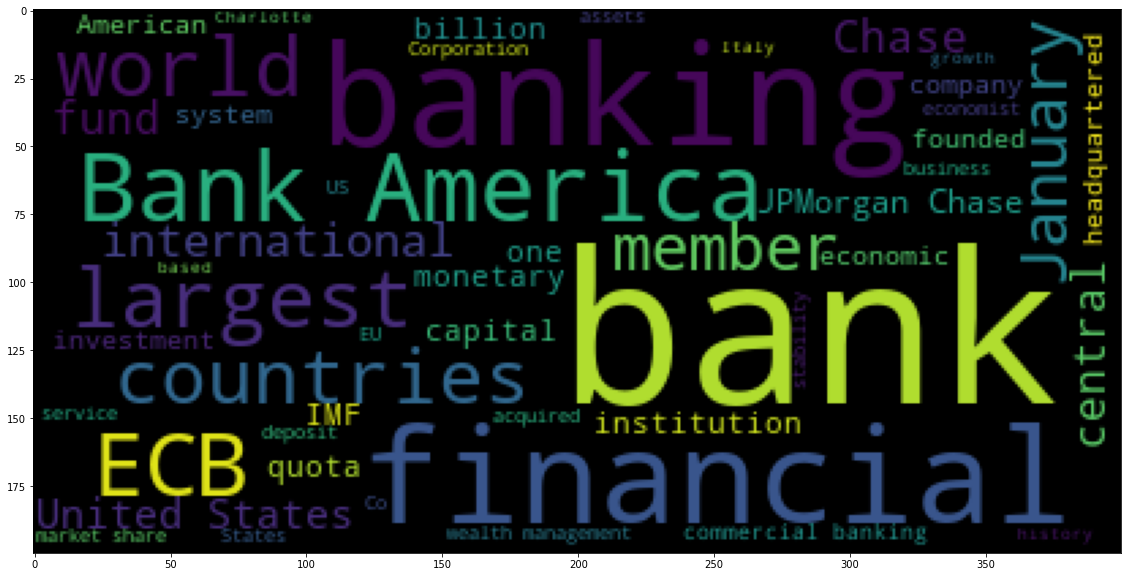

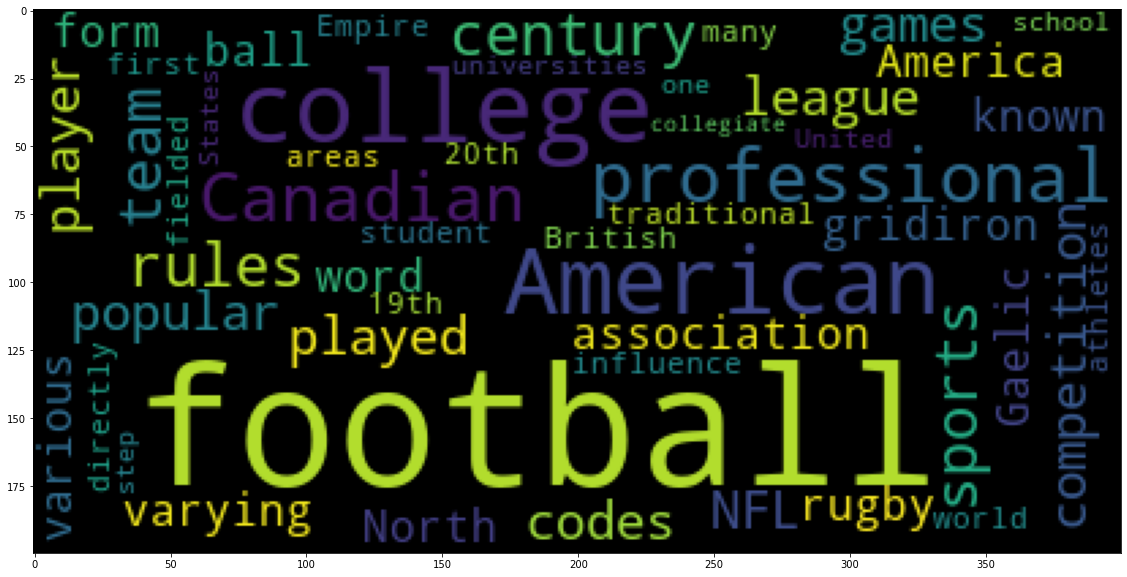

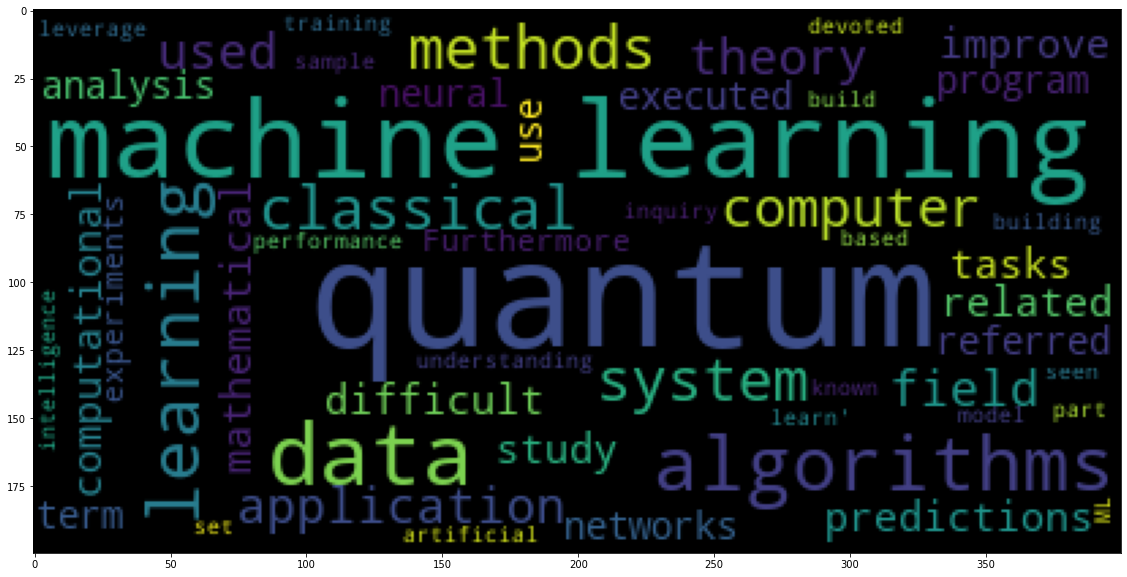

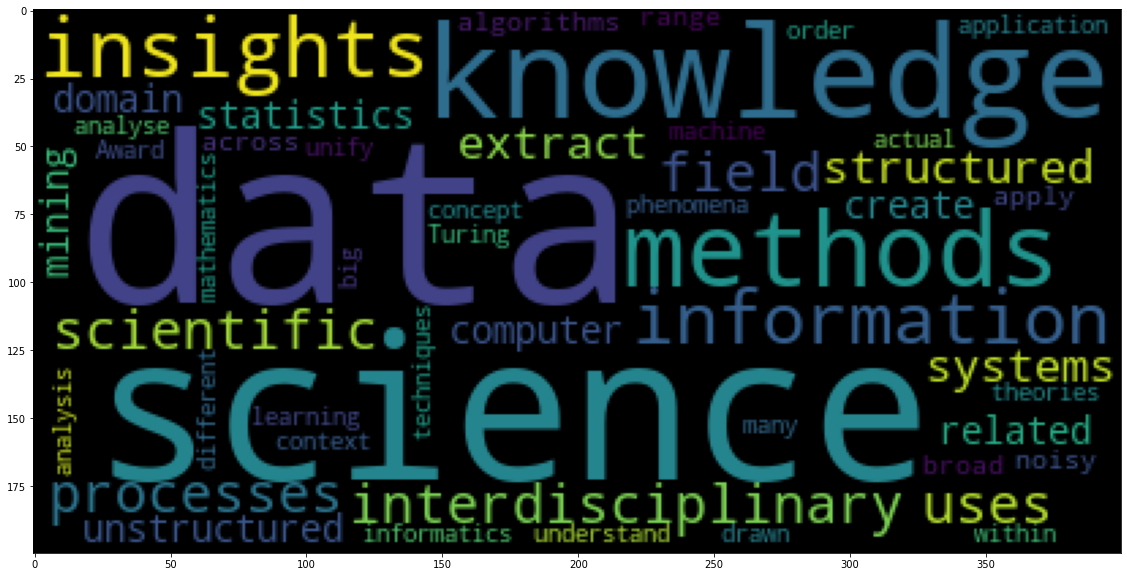

In [ ]:
### importing dependencies for plotting clusters using wordcloud ###
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### plot the clusters using word clouds
word_cloud={'cluster':clusters_formed,'wiki':data}
df_wc=pd.DataFrame(word_cloud)
for i in range(0, 5):
    cluster_i=df_wc[df_wc.cluster==i]
    tokens=cluster_i['wiki'].str.cat(sep=' ')

    word_cloud = WordCloud(max_words=50).generate(tokens)
    plt.figure(figsize=(20, 10))
    plt.imshow(word_cloud)
    plt.axis("on")
    plt.show()
### Below output is just for your reference purposes.
###Your output is not going to be the same as the output provided below as the list of articles is going to be different  

Comment on the clusters formed above. Does they make any sense?

The clusters formed definitely seem to make sense. All the words appearing in the word cloud in a particular cluster are somehow definitely related to each other. For example in the last cluster, we can observe that football is very closely related to the words : Professional, Player, College, League, etc. which is the correct cluster they should all be placed in.The words Banking, America, Acquired, Capital all seem to be clustered together and they all relate to the common topic of Banking and Finance. Hence, we can definitely observe that the clustering algorithm has worked perfectly fine.

# Parts of speech tagging. 

Parts of Speech Tagging is the process of the assigning a parts of speech tag (noun, adjective etc..,) to each word in the input sentence. <br>

In this question we will be building HMMs and Viterbi Algorithm. 

### About the Dataset: <br>

For this task we will be using tagged datasets collected from Wall Street Journal. <br>

The file train.pos will be used for training and test.pos will for testing. Along with these two we will be providing vocab.txt the words in this file are the words from the training set that were used two or more times.<br>

The dataset will contain different tags like JJ which means adjective, DT means determiner etc.., for better understaning of the tags refer to [this link](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html)

In [ ]:
##############################################################################################
##### Dont change anything in this code cell , only change the data paths accordingly  #######
##############################################################################################

#Importing necessary packages

import pandas as pd
from collections import defaultdict
import math
import numpy as np
import string

# Punctuation characters
punct = set(string.punctuation)

# Morphology rules used to assign unknown word tokens
noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
verb_suffix = ["ate", "ify", "ise", "ize"]
adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
adv_suffix = ["ward", "wards", "wise"]

# Utility functions which we further need

def get_word_tag(line, vocab): 
    if not line.split():
        word = "--n--"
        tag = "--s--"
        return word, tag
    else:
        word, tag = line.split()
        if word not in vocab: 
            # Handle unknown words
            word = assign_unk(word)
        return word, tag
    return None 


def preprocess(vocab, data_fp):
    """
    Preprocess data
    """
    orig = []
    prep = []

    # Read data
    with open(data_fp, "r") as data_file:

        for cnt, word in enumerate(data_file):

            # End of sentence
            if not word.split():
                orig.append(word.strip())
                word = "--n--"
                prep.append(word)
                continue

            # Handle unknown words
            elif word.strip() not in vocab:
                orig.append(word.strip())
                word = assign_unk(word)
                prep.append(word)
                continue

            else:
                orig.append(word.strip())
                prep.append(word.strip())

    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep


def assign_unk(tok):
    """
    Assign unknown word tokens
    """
    # Digits
    if any(char.isdigit() for char in tok):
        return "--unk_digit--"

    # Punctuation
    elif any(char in punct for char in tok):
        return "--unk_punct--"

    # Upper-case
    elif any(char.isupper() for char in tok):
        return "--unk_upper--"

    # Nouns
    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Verbs
    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Adjectives
    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Adverbs
    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"

    return "--unk--"


# for viterbi
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue 

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
        ### END CODE HERE ###
    return num_correct/total


# load in the training corpus
with open("training.pos.txt", 'r') as f:
    training_corpus = f.readlines()

# read the vocabulary data, split by each line of text, and save the list
with open("vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

# vocab: dictionary that has the index of the corresponding words
vocab = {} 

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       
    

cnt = 0
for k,v in vocab.items():
    cnt += 1
    if cnt > 20:
        break

# load in the test corpus
with open("test.pos.txt", 'r') as f:
    y = f.readlines()

#corpus without tags, preprocessed
_, prep = preprocess(vocab, "test.words.txt")



### Task 3.1 

In this task we are expected to build a function which takes training_corpus as input and return transition counts, emission counts and tag counts. <br> 



1. `Tranition count`: maps prev_tag, tag) to the number of times it has appeared.
2. `Emission_counts`: maps (tag, word) to the number of times it appeared.
3. `Tag_counts`: maps (tag) to the number of times it has occured.



In [ ]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
            
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # get the word and tag using the get_word_tag helper function
        word, tag = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
        
        ### END CODE HERE ###
        
    return emission_counts, transition_counts, tag_counts

In [ ]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

In [ ]:
# get all the POS states. States are parts of speech designation found in the training dataset.
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


##### Expected Output

```CPP
Number of POS tags (number of 'states'46
View these states
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
```

In [ ]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[:3]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in list(emission_counts.items())[:3]:
    print(tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('IN', 'In'), 1735)
(('DT', 'an'), 3142)
(('NNP', 'Oct.'), 317)

ambiguous word example: 
('IN', 'In') 1735
('DT', 'an') 3142
('NNP', 'Oct.') 317



##### Expected Output

```CPP
transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('IN', 'In'), 1735)
(('DT', 'an'), 3142)
(('NNP', 'Oct.'), 317)

ambiguous word example: 
('IN', 'In') 1735
('DT', 'an') 3142
('NNP', 'Oct.') 317
```

### Task 3.2: 

You need to complete the `predict_pos` function below which takes preprocessed test corpus (prep), Original tagged test corpus `y`, emission counts, vocab and states. <br>

Ultimately in this function for a given preprocessed test corpus, you will assign a parts-of-speech tag to every word in that corpus. Using the original tagged test corpus, you will then compute what percent of the tags you got correct. <br>

In [ ]:
def predict_pos(prep, y, emission_counts, vocab, states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
        # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    total = len(y)
    for word, tuple_y in zip(prep, y):
        tuple_y_l = tuple_y.split()
        if len(tuple_y_l) == 2:
            true_label = tuple_y_l[1]
        else:
            continue
    
        count_final = 0
        pos_final = ''
        if word in vocab:
            for pos in states:
                key = (pos,word)
                if key in emission_counts:
                    count = emission_counts[key]
                    if count>count_final:
                        count_final = count
                        pos_final = pos
            if pos_final == true_label:
                num_correct += 1
                
       ### END CODE HERE ###
    accuracy = num_correct / total
    
    return accuracy

In [ ]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


##### Expected Output

```CPP
Accuracy of prediction using predict_pos is 0.8889
```

### Task 3.3 Building Hidden Markov Models for POS.

**Hidden Markov Models** (HMMs) are a class of probabilistic graphical model that allow us to predict a sequence of unknown (hidden) variables from a set of observed variables. <br>

The Markov Model contains a number of states and the probability of transition between those states. 
- In this case, the states are the parts-of-speech. 
- A Markov Model utilizes a transition matrix, `A`. 
- A Hidden Markov Model adds an observation or emission matrix `B` which describes the probability of a visible observation when we are in a particular state. 
- In this case, the emissions are the words in the corpus
- The state, which is hidden, is the POS tag of that word.


### Creating the 'A' transition probabilities matrix

We will be using Smoothing to compute the matrix. 

The smoothing was done as follows: 

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

In [ ]:
# GRADED FUNCTION: create_transition_matrix
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    num_tags = len(tag_counts)
    A = np.zeros((num_tags, num_tags))
    # Write your code here
    sorted_tags = sorted(tag_counts.keys())
    num_tags = len(sorted_tags)
    A = np.zeros((num_tags,num_tags))
    trans_keys = set(transition_counts.keys())
    for i in range(num_tags):
        for j in range(num_tags):
            count = 0
            key = (sorted_tags[i], sorted_tags[j])
            if transition_counts:
                count = transition_counts[key]
            count_prev_tag = tag_counts[sorted_tags[i]]
            A[i,j] = (count + alpha) / (count_prev_tag + alpha*num_tags)    
    return A

In [ ]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,5]:.9f}")
print(f"A at row 3, col 1: {A[3,6]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[10:15,10:15], index=states[10:15], columns = states[10:15] )
print(A_sub)

A at row 0, col 0: 0.007047013
A at row 3, col 1: 0.0000
View a subset of transition matrix A
          CD        DT            EX        FW        IN
CD  0.201542  0.028850  2.734628e-08  0.000055  0.089997
DT  0.022922  0.001576  1.221866e-08  0.000257  0.009665
EX  0.000001  0.002319  1.158687e-06  0.000001  0.000001
FW  0.000004  0.008550  4.272664e-06  0.239273  0.029913
IN  0.059328  0.328388  1.582898e-03  0.000203  0.020415


#### Expected Output: 

```CPP
A at row 0, col 0: 0.007047013
A at row 3, col 1: 0.0000
View a subset of transition matrix A
          CD        DT            EX        FW        IN
CD  0.201542  0.028850  2.734628e-08  0.000055  0.089997
DT  0.022922  0.001576  1.221866e-08  0.000257  0.009665
EX  0.000001  0.002319  1.158687e-06  0.000001  0.000001
FW  0.000004  0.008550  4.272664e-06  0.239273  0.029913
IN  0.059328  0.328388  1.582898e-03  0.000203  0.020415
```

### Creating 'B' emission probabilities matrix

Now you will create the `B` transition matrix which computes the emission probability. 

You will use smoothing as defined below: 

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: create_emission_matrix

def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    num_tags = len(tag_counts)
    num_words = len(vocab)
    B = np.zeros((num_tags, num_words))
    sorted_tags = sorted(tag_counts.keys())
    emis_keys = set(list(emission_counts.keys()))
    for i in range(num_tags):
        for j in range(num_words):
            count = 0
            key =  (sorted_tags[i],vocab[j])
            if key in emission_counts.keys():
                count = emission_counts[key]
            count_tag = tag_counts[sorted_tags[i]]
            B[i,j] = (count + alpha) / (count_tag+ alpha*num_words)
    return B

In [ ]:
# creating your emission probability matrix. this takes a few minutes to run. 
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


#### Expected Output: 

```CPP
View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07
```

### Task 3.4 Viterbi Algorithm

In this part of the code we will implement the Viterbi algorithm. Specifically, you will use your two matrices, `A` and `B` to compute the Viterbi algorithm. 

We have decomposed this process into three main parts. 

* **Initialization** - In this part you initialize the `best_paths` and `best_probabilities` matrices that you will be populating in `feed_forward`.
* **Feed forward** - At each step, you calculate the probability of each path happening and the best paths up to that point. 
* **Feed backward**: This allows you to find the best path with the highest probabilities. 

### Task 3.4.1 Initialization 
Write a program below that initializes the `best_probs` and the `best_paths` matrix. 

Both matrices will be initialized to zero except for column zero of `best_probs`.  
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--"). 
- This allows you to reference the **A** matrix for the transition probability

Here is how to initialize column 0 of `best_probs`:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus). 
- **vocab** is a dictionary that returns the unique integer that refers to that particular word.


In [ ]:
import math

# GRADED FUNCTION: initialize
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    sorted_tags = sorted(states)
    num_tags = len(tag_counts)
    best_probs = np.zeros((num_tags, len(corpus)))
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    state_index = states.index("--s--")
    for i in range(num_tags):
        if A[state_index,i] == 0:
            best_probs[i,0] = float('-inf')
        else:
            best_probs[i,0] = math.log(A[state_index,i]) + math.log(B[i,vocab[corpus[0]]] )
           
    return best_probs, best_paths

In [ ]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [ ]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


#### Expected Output: 

```CPP
best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000
```

### Task 3.4.2 Viterbi Forward Implementation

In this part of the assignment, you will implement the `viterbi_forward` segment. In other words, you will populate your `best_probs` and `best_paths` matrices.
- Walk forward through the corpus.
- For each word, compute a probability for each possible tag. 

Store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudo code below.

`for each word in the corpus

    for each POS tag type that this word may be
    
        for POS tag type that the previous word could be
        
            compute the probability that the previous word had a given POS tag, that the current word has a given POS tag, and that the POS tag would emit this current word.
            
            retain the highest probability computed for the current word
            
            set best_probs to this highest probability
            
            set best_paths to the index 'k', representing the POS tag of the previous word which produced the highest probability `

In [ ]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab, corpus):
    '''
    Input: 
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    num_tags = best_probs.shape[0]
    for i in range(1, len(test_corpus)):
        for j in range(num_tags):
            best_prob_i = float("-inf")
            best_path_i = None
            for k in range(num_tags):
                prob = best_probs[k,i-1]+math.log(A[k,j]) +math.log(B[j,vocab[test_corpus[i]]])
                if prob > best_prob_i:
                    best_prob_i = prob
                    best_path_i = k
            best_probs[j,i] = best_prob_i
            best_paths[j,i] = best_path_i
    return best_probs, best_paths

In [ ]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab, prep)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [ ]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


#### Expected Output: 

```CPP
best_probs[0,1]: -35.2828
best_probs[0,4]: -54.4040
```

### Task 3.4.3 Viterbi Backward Implementation

<a name='2.4'></a>
## Part 2.4 Viterbi backward

Now you will implement the Viterbi backward algorithm.
- The Viterbi backward algorithm gets the predictions of the POS tags for each word in the corpus using the `best_paths` and the `best_probs` matrices.

The example below shows how to walk backwards through the best_paths matrix to get the POS tags of each word in the corpus. Recall that this example corpus has three words: "Loss tracks upward".

POS tag for 'upward' is `RB`
- Select the the most likely POS tag for the last word in the corpus, 'upward' in the `best_prob` table.
- Look for the row in the column for 'upward' that has the largest probability.
- Notice that in row 28 of `best_probs`, the estimated probability is -34.99, which is larger than the other values in the column.  So the most likely POS tag for 'upward' is `RB` an adverb, at row 28 of `best_prob`. 
- The variable `z` is an array that stores the unique integer ID of the predicted POS tags for each word in the corpus.  In array z, at position 2, store the value 28 to indicate that the word 'upward' (at index 2 in the corpus), most likely has the POS tag associated with unique ID 28 (which is `RB`).
- The variable `pred` contains the POS tags in string form.  So `pred` at index 2 stores the string `RB`.


POS tag for 'tracks' is `VBZ`
- The next step is to go backward one word in the corpus ('tracks').  Since the most likely POS tag for 'upward' is `RB`, which is uniquely identified by integer ID 28, go to the `best_paths` matrix in column 2, row 28.  The value stored in `best_paths`, column 2, row 28 indicates the unique ID of the POS tag of the previous word.  In this case, the value stored here is 40, which is the unique ID for POS tag `VBZ` (verb, 3rd person singular present).
- So the previous word at index 1 of the corpus ('tracks'), most likely has the POS tag with unique ID 40, which is `VBZ`.
- In array `z`, store the value 40 at position 1, and for array `pred`, store the string `VBZ` to indicate that the word 'tracks' most likely has POS tag `VBZ`.

POS tag for 'Loss' is `NN`
- In `best_paths` at column 1, the unique ID stored at row 40 is 20.  20 is the unique ID for POS tag `NN`.
- In array `z` at position 0, store 20.  In array `pred` at position 0, store `NN`.


In [ ]:
# GRADED FUNCTION: viterbi_backward
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    m = best_paths.shape[1]
    z = [None] * m
    num_tags = best_probs.shape[0]
    maxProb = float('-inf')
    pred = [None] * m
    for k in range(num_tags):
        if best_probs[k,-1]>maxProb:
            maxProb = best_probs[k,-1]
            z[m - 1] = k
    pred[m - 1] = states[k]
    for i in range(len(corpus)-1, -1, -1):
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        pred[i - 1] = states[pos_tag_for_word_i]
    return pred

In [ ]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


#### Expected Output: 

```CPP
The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']
```

### Predicting on the dataset and print accuracy

In [ ]:
print('The word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

The word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN

Accuracy of the Viterbi algorithm is 0.9528


#### Expected Output: 

```CPP
The word is: points
Your prediction is: VBZ
Your corresponding label y is:  points	NNS

Accuracy of the Viterbi algorithm is 0.9531
```